In [3]:
!apt-get update
!apt-get install -y ffmpeg
!apt-get install xvfb
!apt-get install swig3.0
%pip install pyvirtualdisplay
%pip install gym
%pip install Pillow
%pip install swig
%pip install gym[box2d]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,107 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [61.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [4]:
import time
import numpy as np
import PIL.Image
import tensorflow as tf
from collections import deque
from collections import namedtuple
import gym
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [19]:
GAMMA = 0.985
ALPHA = 1e-3
MEMORY_SIZE = 100_000
NUM_STEPS_FOR_UPDATE = 5

In [20]:
import base64
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import tensorflow as tf
from itertools import zip_longest
import imageio
import IPython

from statsmodels.iolib.table import SimpleTable

SEED = 0
MINIBATCH_SIZE = 64
TAU = 1e-3
E_DECAY = 0.995
E_MIN = 0.01

random.seed(SEED)

def obter_experiencias(buffer_de_memoria):
    experiencias = random.sample(buffer_de_memoria, k=MINIBATCH_SIZE)
    estados = tf.convert_to_tensor(np.array([e.estado for e in experiencias if e is not None]),dtype=tf.float32)
    acoes = tf.convert_to_tensor(np.array([e.acao for e in experiencias if e is not None]), dtype=tf.float32)
    recompensas = tf.convert_to_tensor(np.array([e.recompensa for e in experiencias if e is not None]), dtype=tf.float32)
    proximos_estados = tf.convert_to_tensor(np.array([e.proximo_estado for e in experiencias if e is not None]),dtype=tf.float32)
    valores_de_finalizacao = tf.convert_to_tensor(np.array([e.finalizado for e in experiencias if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (estados, acoes, recompensas, proximos_estados, valores_de_finalizacao)

def verificar_condicoes_atualizacao(t, num_passos_atualizacao, buffer_de_memoria):
    if (t + 1) % num_passos_atualizacao == 0 and len(buffer_de_memoria) > MINIBATCH_SIZE:
        return True
    else:
        return False

def obter_novo_eps(epsilon):
    return max(E_MIN, E_DECAY * epsilon)

def obter_acao(valores_q, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(valores_q.numpy()[0])
    else:
        return random.choice(np.arange(4))

def atualizar_rede_alvo(rede_q, rede_alvo_q):
    for pesos_alvo, pesos_rede_q in zip(rede_alvo_q.weights, rede_q.weights):
        pesos_alvo.assign(TAU * pesos_rede_q + (1.0 - TAU) * pesos_alvo)

def plotar_historico(historico_recompensa, janela_deslizante=20, limite_inferior=None,
limite_superior=None, plotar_recompensa=True, plotar_media=True):
    if limite_inferior is None or limite_superior is None:
        rh = historico_recompensa
        xs = [x for x in range(len(historico_recompensa))]
    else:
        rh = historico_recompensa[limite_inferior:limite_superior]
        xs = [x for x in range(limite_inferior, limite_superior)]

    df = pd.DataFrame(rh)
    media_deslizante = df.rolling(janela_deslizante).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plotar_recompensa:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plotar_media:
        plt.plot(xs, media_deslizante, linewidth=2, color='magenta')

    cor_texto = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
    plt.xlabel('Episódio', color=cor_texto, fontsize=30)
    plt.ylabel('Pontuação total', color=cor_texto, fontsize=30)
    formato_numerico_y = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(formato_numerico_y)
    ax.tick_params(axis='x', colors=cor_texto)
    ax.tick_params(axis='y', colors=cor_texto)
    plt.show()

Display(visible=0, size=(840, 480)).start();
tf.random.set_seed(SEED)

env = gym.make('LunarLander-v2')

In [33]:
tamanho_estado = env.observation_space.shape
num_acoes = env.action_space.n

print('estado formato:', tamanho_estado)
print('ações:', num_acoes)


estado formato: (8,)
ações: 4


In [25]:
estado_inicial = env.reset()
acao = 0
prox_estado, recompensa, terminado, info = env.step(acao)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("estado inicial:", estado_inicial)
    print("ação:", acao)
    print("próximo Estado:", prox_estado)
    print("recompensa:", recompensa)
    print("episódio finalizado:", terminado)

Estado Inicial: [-0.004 1.415 -0.424 0.184 0.005 0.096 0.000 0.000]
Ação: 0
Próximo Estado: [-0.008 1.419 -0.424 0.158 0.010 0.095 0.000 0.000]
Recompensa Recebida: 0.17996249505563355
Episódio Terminado: False
Informação: {}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [26]:
rede_q = Sequential([
    Input(shape=tamanho_estado),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_acoes, activation='linear'),
])

rede_q_alvo = Sequential([
    Input(shape=tamanho_estado),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_acoes, activation='linear'),
])

otimizador = Adam(learning_rate=ALPHA)


In [27]:
Experiencia = namedtuple("experiencia", field_names=["estado", "acao", "recompensa", "proximo_estado", "finalizado"])


In [28]:
def calcular_perda(experiencias, gamma, rede_q, rede_q_alvo):
    estados, acoes, recompensas, proximos_estados, valores_de_finalizacao = experiencias
    max_qsa = tf.reduce_max(rede_q_alvo(proximos_estados), axis=-1)
    y_alvos = recompensas + (gamma * max_qsa * (1 - valores_de_finalizacao))
    valores_q = rede_q(estados)
    valores_q = tf.gather_nd(valores_q, tf.stack([tf.range(valores_q.shape[0]),
    tf.cast(acoes, tf.int32)], axis=1))
    perda = MSE(y_alvos, valores_q)
    return perda


In [29]:
@tf.function
def aprender_agente(experiencias, gamma):
    with tf.GradientTape() as fita:
      perda = calcular_perda(experiencias, gamma, rede_q, rede_q_alvo)
      gradientes = fita.gradient(perda, rede_q.trainable_variables)
      otimizador.apply_gradients(zip(gradientes, rede_q.trainable_variables))
      atualizar_rede_alvo(rede_q, rede_q_alvo)


In [31]:
inicio = time.time()

num_episodios = 1000
max_num_passos = 1000
historico_pontos_total = []
num_pontos_av = 100
epsilon = 1.0
buffer_memoria = deque(maxlen=MEMORY_SIZE)
rede_q_alvo.set_weights(rede_q.get_weights())
for i in range(num_episodios):
    estado = env.reset()
    pontos_total = 0
    for t in range(max_num_passos):
        estado_rede_q = np.expand_dims(estado, axis=0)
        valores_q = rede_q(estado_rede_q)
        acao = obter_acao(valores_q, epsilon)
        prox_estado, recompensa, terminado, _ = env.step(acao)
        buffer_memoria.append(Experiencia(estado, acao, recompensa, prox_estado, terminado))
        atualizar = verificar_condicoes_atualizacao(t, NUM_STEPS_FOR_UPDATE, buffer_memoria)
        if atualizar:
            experiencias = obter_experiencias(buffer_memoria)
            aprender_agente(experiencias, GAMMA)
        estado = prox_estado.copy()
        pontos_total += recompensa
        if terminado:
            break

    historico_pontos_total.append(pontos_total)
    media_pontos_recentes = np.mean(historico_pontos_total[-num_pontos_av:])
    epsilon = obter_novo_eps(epsilon)
    print(f"\rEpisódio {i+1} ")
    if (i+1) % num_pontos_av == 0:
        print(f"\rEpisódio {i+1} ")
    if media_pontos_recentes >= 200.0:
        print(f"\n\n ambiente finalizado em {i+1} episódios")
        rede_q.save('lunar_lander_model.h5')
        break

Episódio 1 
Episódio 2 
Episódio 3 
Episódio 4 
Episódio 5 
Episódio 6 
Episódio 7 
Episódio 8 
Episódio 9 
Episódio 10 
Episódio 11 
Episódio 12 
Episódio 13 
Episódio 14 
Episódio 15 
Episódio 16 
Episódio 17 
Episódio 18 
Episódio 19 
Episódio 20 
Episódio 21 
Episódio 22 
Episódio 23 
Episódio 24 
Episódio 25 
Episódio 26 
Episódio 27 
Episódio 28 
Episódio 29 
Episódio 30 
Episódio 31 
Episódio 32 
Episódio 33 
Episódio 34 
Episódio 35 
Episódio 36 
Episódio 37 
Episódio 38 
Episódio 39 
Episódio 40 
Episódio 41 
Episódio 42 
Episódio 43 
Episódio 44 
Episódio 45 
Episódio 46 
Episódio 47 
Episódio 48 
Episódio 49 
Episódio 50 
Episódio 51 
Episódio 52 
Episódio 53 
Episódio 54 
Episódio 55 
Episódio 56 
Episódio 57 
Episódio 58 
Episódio 59 
Episódio 60 
Episódio 61 
Episódio 62 
Episódio 63 
Episódio 64 
Episódio 65 
Episódio 66 
Episódio 67 
Episódio 68 
Episódio 69 
Episódio 70 
Episódio 71 
Episódio 72 
Episódio 73 
Episódio 74 
Episódio 75 
Episódio 76 
Episódio 77 
Episódio

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episódio 749 


 ambiente finalizado em 749 episódios

Tempo Total: 1787.17 s (29.79 min)


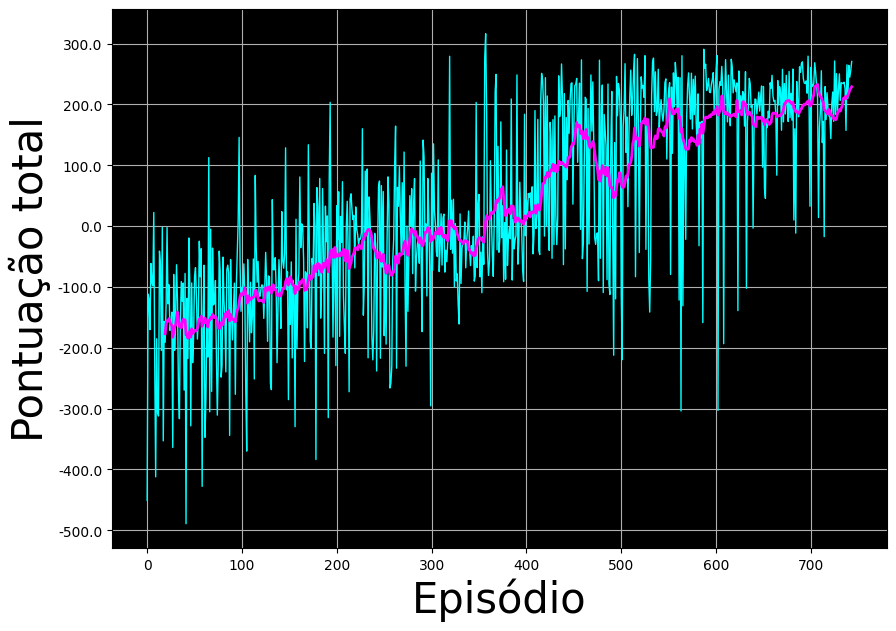

In [32]:
plot_history(total_point_history)